数据建模流程：
1. 原始数据获取：原始数据字典、原始字段分析、清洗逻辑
2. 数据预处理：ETL加工、缺失值、异常值
3. 特征工程：指标体系构建、模型变量字典、衍生变量计算、入模变量重要性筛选
4. 模型训练：算法选择、交叉验证、参数调整
5. 模型评价与优化：模型结果比较、效果评估（AUC、KS）、模型解释
6. 模型上线：上线部署、接口联调

## 载入函数库

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

## 自定义函数库

In [16]:
###生成原始数据
#n_points：数据个数，默认1000
def produce_data(n_points=1000):
    data = pd.DataFrame()
    #选定随机种子
    np.random.seed(0)
    #生成特征
    data['practice'] = np.random.random(n_points)
    data['time_period'] = np.random.random(n_points)
    #生成噪音
    data['error'] = np.random.random(n_points)
    #生成类别标签
    data['label'] = np.round(data['practice'] * data['time_period'] + 0.3 + 0.1 * data['error'])
    data['label'][data['practice'] > 0.8] = 1
    data['label'][data['time_period'] > 0.8] = 1
    return(data)

In [25]:
###测试集数据可视化
#clf：训练好的分类器
#X_test：测试数据特征
#Y_test：测试数据类别
def plot_pic(clf,X_test,Y_test):
    x_min = 0.0; x_max = 1.0
    y_min = 0.0; y_max = 1.0
    #画出决策边界，为每一个点绘制一个颜色
    step = .01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min,y_max,step))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    #绘图
    Z = Z.reshape(xx.shape)
    plt.xlim(xx.min(),xx.max())
    plt.ylim(yy.min(),yy.max())
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.RdYlBu)
    data = X_test.copy()
    data['label'] = Y_test
    practice_fail = data[data['label'] == 0]['practice']
    time_period_fail = data[data['label'] == 0]['time_period']
    practice_pass = data[data['label'] == 1]['practice']
    time_period_pass = data[data['label'] == 1]['time_period']
    plt.scatter(practice_fail, time_period_fail, color='b',label='fail')
    plt.scatter(practice_pass, time_period_pass, color='r',label='pass')
    plt.legend()
    plt.xlabel('practice')
    plt.ylabel('time_period')
    plt.legend(loc='upper right')
    plt.show()

In [18]:
###计算模型准确性AUC
#data：测试数据
#score_col：测试数据预测值
#class_col：测试数据实际类别
from sklearn.metrics import roc_curve,auc
def auc_calc(data,score_col,class_col):
    auc_dict = {}
    fpr,tpr,threshold = roc_curve((1-data[class_col[0]]).ravel(),data[score_col[0]].ravel())
    roc_auc = auc(fpr,tpr)
    fig = plt.figure()
    plt.plot(fpr,tpr,color='b',label='ROC Curve (area=%0.3f)'%roc_auc,alpha=0.3)
    plt.plot([0,1],[0,1],color='r',linestyle='--',alpha=0.3)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve of %s'%score_col[0])
    plt.legend(loc='lower right')
    plt.close()
    auc_dict['auc'] = roc_auc
    auc_dict['auc_fig'] = fig
    return auc_dict

AUC：感受性曲线下面积（AUC，Area Under Curve）是一个从整体上评价模型准确性的指标，是感受性曲线（ROC，Receiver Operating Characteristic）与横轴之间的面积。相比于其他评价指标，ROC具有一定的稳定性，它不会因为正负样本分布的变化而产生不同的曲线。ROC通过真阳率（TPR，Ture Positive Rate）和假阳率（FPR，False Positive Rate）两个指标进行绘制。在实际项目中，AUC0.8以上代表模型准确性高。

In [102]:
###计算模型区分度KS
#data：测试数据
#score_col：测试数据预测值
#class_col：测试数据实际类别
from scipy import stats
def ks_calc(data,score_col,class_col):
    ks_dict = {}
    Bad = data.ix[data[class_col[0]]==1,score_col[0]]
    Good = data.ix[data[class_col[0]]==0, score_col[0]]
    ks,pvalue = stats.ks_2samp(Bad.values,Good.values)
    crossfreq = pd.crosstab(data[score_col[0]],data[class_col[0]])
    crossdens = crossfreq.cumsum(axis=0) / crossfreq.sum()
    crossdens['gap'] = abs(crossdens[0] - crossdens[1])
    score_split = crossdens[crossdens['gap'] == crossdens['gap'].max()].index[0]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    crossdens[[0,1]].plot(kind='line',ax=ax)
    ax.set_xlabel('%s' % score_col[0])
    ax.set_ylabel('Density')
    ax.set_title('CDF Curve of Classified %s' % score_col[0])
    plt.close()
    ks_dict['ks'] = ks
    ks_dict['split'] = score_split
    ks_dict['ks_fig'] = fig
    return ks_dict

KS：区分度指标（KS，Kolmogorov-Smirnov）是度量具体模型下正常样本和违约样本分布的最大差距，首先按照样本的信用分数或预测违约率从小到大进行排序，然后计算每一个分数或违约率下好坏样本的累计占比。正常和违约样本的累计占比差值的最大值即为KS。KS小于0.2代表模型区分度低，超过0.75代表模型区分度高。在实际项目中，KS0.5以上都可以接受。

## 生成原始数据

In [5]:
data = produce_data()
data.iloc[:5,:]

,practice,time_period,error,label
0,0.548814,0.592880,0.811518,1.0
1,0.715189,0.010064,0.476084,0.0
2,0.602763,0.475826,0.523156,1.0
3,0.544883,0.708770,0.250521,1.0
4,0.423655,0.043975,0.605043,0.0


In [6]:
data.shape

(1000, 4)

In [8]:
X_data = data[['practice','time_period']]
Y_data = data['label']
print(X_data.shape,Y_data.shape)

(1000, 2) (1000,)


## 划分测试集和训练集

In [35]:
X_train,X_test,Y_train,Y_test = train_test_split(X_data,Y_data,test_size=0.2,random_state=0)
Y_train = pd.DataFrame(Y_train)
Y_test = pd.DataFrame(Y_test)
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(800, 2) (200, 2) (800, 1) (200, 1)


##  训练集数据展示

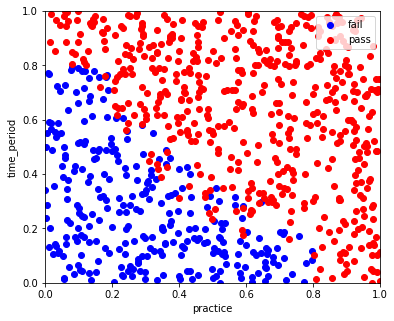

In [14]:
#区分好坏人
train_data = X_train.copy()
train_data['label'] = Y_train
practice_fail = train_data[train_data['label'] == 0]['practice']
time_period_fail = train_data[train_data['label']==0]['time_period']
practice_pass = train_data[train_data['label'] == 1]['practice']
time_period_pass = train_data[train_data['label']==1]['time_period']
#可视化作图
plt.figure(figsize=(6,5))
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.scatter(practice_fail, time_period_fail, color = 'b', label='fail')
plt.scatter(practice_pass, time_period_pass, color = 'r', label='pass')
plt.xlabel('practice')
plt.ylabel('time_period')
plt.legend(loc='upper right')
plt.show()

## 训练逻辑回归模型

逻辑回归适合处理线性数据，而实际问题往往是非线性的，特别是在信用风险评估场景下。

本章重点数学知识：线性回归、偏导数、凸函数、Sigmoid函数、条件概率、二项分布

算法理论详见周志华《机器学习》3.1、3.2、3.3

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


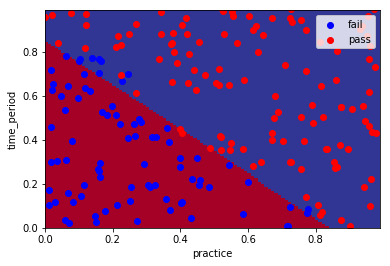

In [42]:
###第一个逻辑回归模型（penalty='l1',C=1）
lr = LogisticRegression(penalty='l1',C=1,random_state=0)
lr.fit(X_train,Y_train)
Y_test['pred'] = lr.predict_proba(X_test)
plot_pic(lr,X_test,Y_test['label']) 

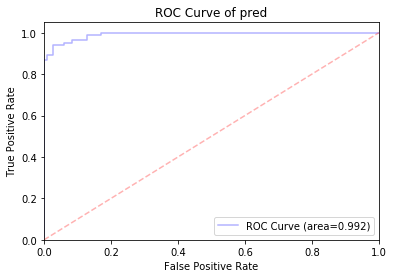

In [43]:
auc_fig = auc_calc(Y_test,['pred'],['label'])['auc_fig']
auc_fig

0.878048780488
0.406458990111


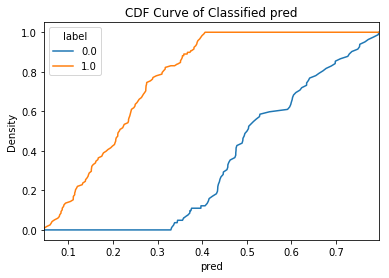

In [87]:
ks_dict = ks_calc(Y_test,['pred'],['label'])
print(ks_dict['ks'])
print(ks_dict['split'])
ks_dict['ks_fig']

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


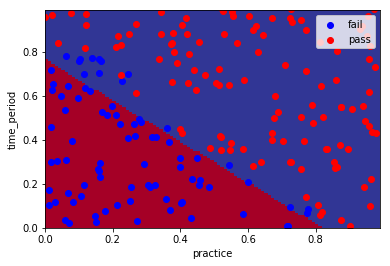

In [62]:
###第二个逻辑回归模型（penalty='l1',C=0.1）
lr = LogisticRegression(penalty='l1',C=0.1,random_state=0)
lr.fit(X_train,Y_train)
Y_test['pred'] = lr.predict_proba(X_test)
plot_pic(lr,X_test,Y_test['label']) 

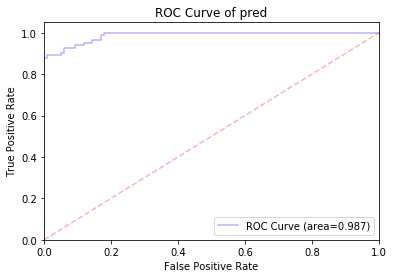

In [63]:
auc_fig = auc_calc(Y_test,['pred'],['label'])['auc_fig']
auc_fig

0.878048780488
0.406458990111


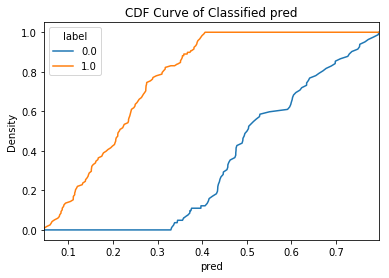

In [88]:
ks_dict = ks_calc(Y_test,['pred'],['label'])
print(ks_dict['ks'])
print(ks_dict['split'])
ks_dict['ks_fig']

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


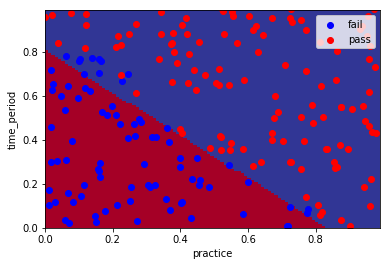

In [65]:
###第三个逻辑回归模型（penalty='l2',C=1）
lr = LogisticRegression(penalty='l2',C=1,random_state=0)
lr.fit(X_train,Y_train)
Y_test['pred'] = lr.predict_proba(X_test)
plot_pic(lr,X_test,Y_test['label']) 

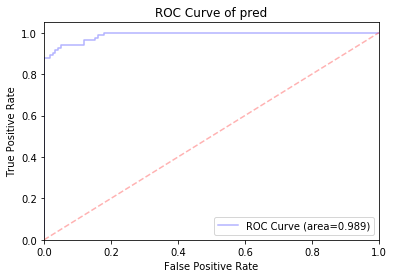

In [66]:
auc_fig = auc_calc(Y_test,['pred'],['label'])['auc_fig']
auc_fig

0.878048780488
0.406458990111


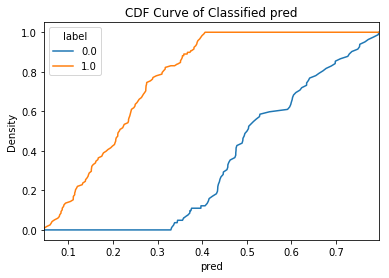

In [89]:
ks_dict = ks_calc(Y_test,['pred'],['label'])
print(ks_dict['ks'])
print(ks_dict['split'])
ks_dict['ks_fig']

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


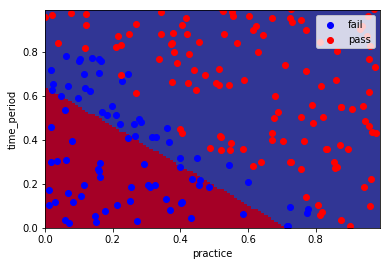

In [107]:
###第四个逻辑回归模型（penalty='l2',C=0.1）
lr = LogisticRegression(penalty='l2',C=0.1,random_state=0)
lr.fit(X_train,Y_train)
Y_test['pred'] = lr.predict_proba(X_test)
plot_pic(lr,X_test,Y_test['label']) 

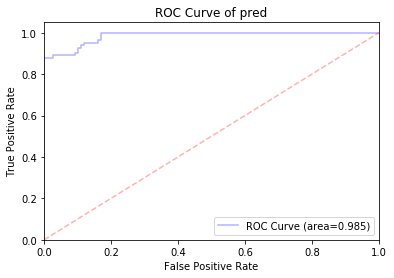

In [69]:
auc_fig = auc_calc(Y_test,['pred'],['label'])['auc_fig']
auc_fig

0.878048780488
0.406458990111


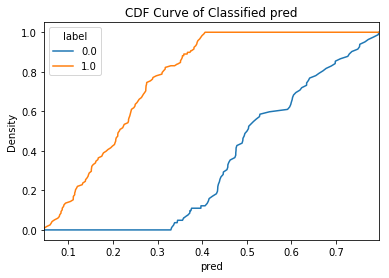

In [90]:
ks_dict = ks_calc(Y_test,['pred'],['label'])
print(ks_dict['ks'])
print(ks_dict['split'])
ks_dict['ks_fig']

## 训练k近邻模型

k近邻的主要不足在于受到样本不平衡的影响；如果一个类样本占比较大，有可能导致输入一个新的样本时，该样本的k个邻居中占比较大的样本占多数。

本章重点数学知识：条件概率、全概率公式、贝叶斯概率公式

算法理论详见周志华《机器学习》10.1

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


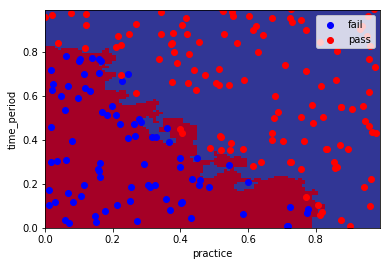

In [99]:
###第一个k近邻模型（n_neighbors=3）
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,Y_train)
Y_test['pred'] = knn.predict_proba(X_test)
plot_pic(knn,X_test,Y_test['label']) 

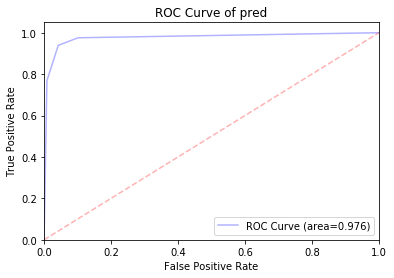

In [100]:
auc_fig = auc_calc(Y_test,['pred'],['label'])['auc_fig']
auc_fig

0.896651508888
0.333333333333


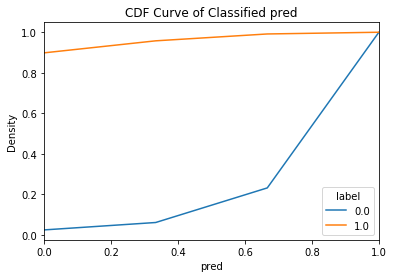

In [101]:
ks_dict = ks_calc(Y_test,['pred'],['label'])
print(ks_dict['ks'])
print(ks_dict['split'])
ks_dict['ks_fig']

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


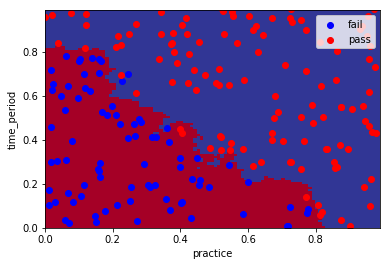

In [112]:
###第二个k近邻模型（n_neighbors=10）
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train,Y_train)
Y_test['pred'] = knn.predict_proba(X_test)
plot_pic(knn,X_test,Y_test['label'])

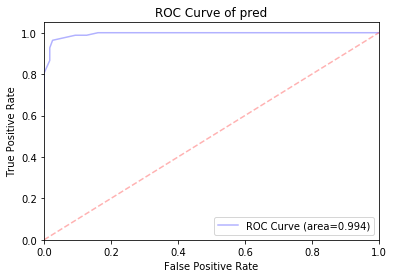

In [113]:
auc_fig = auc_calc(Y_test,['pred'],['label'])['auc_fig']
auc_fig

0.937990905333
0.4


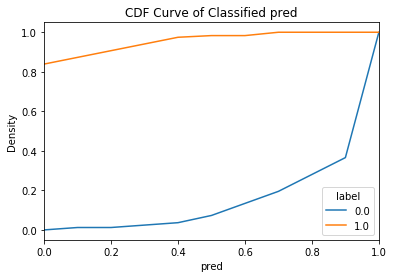

In [115]:
ks_dict = ks_calc(Y_test,['pred'],['label'])
print(ks_dict['ks'])
print(ks_dict['split'])
ks_dict['ks_fig']

## 训练朴素贝叶斯模型

朴素贝叶斯模型的前提假设是特征之间相互独立，这个假设在实际应用中往往是不成立的；因而在特征个数较多或者特征之间相关性较大时，朴素贝叶斯的分类效果有限。

本章重点数学知识：贝叶斯概率公式、对数计算、条件概率、正态分布密度函数

算法理论详见周志华《机器学习》7.1、7.2、7.3

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


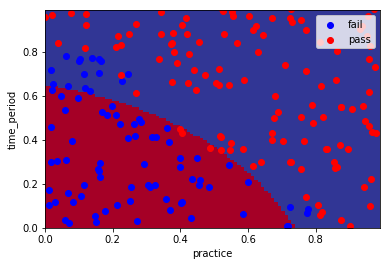

In [117]:
nb = GaussianNB(priors=None)
nb.fit(X_train,Y_train)
Y_test['pred'] = nb.predict_proba(X_test)
plot_pic(nb,X_test,Y_test['label'])

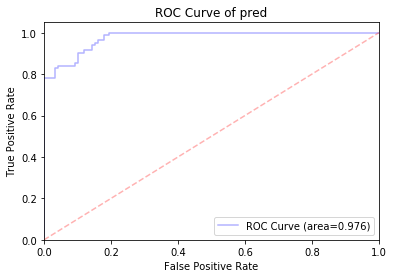

In [118]:
auc_fig = auc_calc(Y_test,['pred'],['label'])['auc_fig']
auc_fig

0.809838776354
0.191387193917


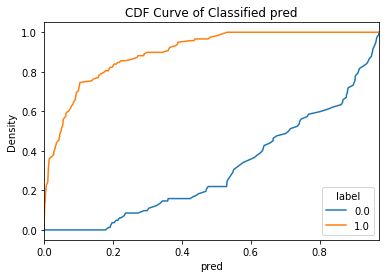

In [119]:
ks_dict = ks_calc(Y_test,['pred'],['label'])
print(ks_dict['ks'])
print(ks_dict['split'])
ks_dict['ks_fig']

## 训练支持向量机模型

支持向量机能够通过核函数等方法处理非线性数据，然而存在样本量大时训练速度太慢的问题；线性支持向量机的分类结果与逻辑回归模型接近。

本章重点数学知识：拉格朗日函数、偏导数、映射、高斯核函数

算法理论详见周志华《机器学习》6.1、6.2、6.3、6.4

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


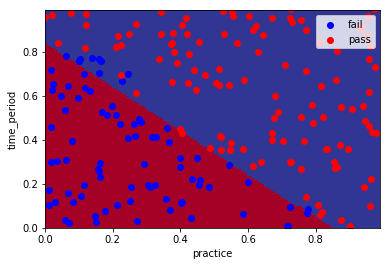

In [122]:
###第一个支持向量机模型（C=1,kernel='linear'）
svc = SVC(C=1,kernel='linear',probability=True,random_state=0)
svc.fit(X_train,Y_train)
Y_test['pred'] = svc.predict_proba(X_test)
plot_pic(svc,X_test,Y_test['label'])

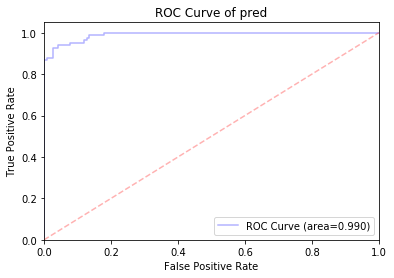

In [123]:
auc_fig = auc_calc(Y_test,['pred'],['label'])['auc_fig']
auc_fig

0.901405539479
0.406030896405


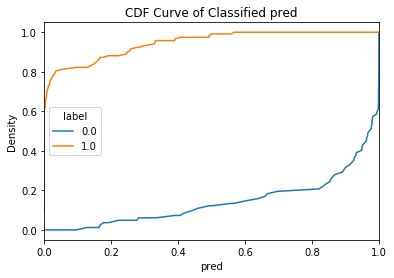

In [124]:
ks_dict = ks_calc(Y_test,['pred'],['label'])
print(ks_dict['ks'])
print(ks_dict['split'])
ks_dict['ks_fig']

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


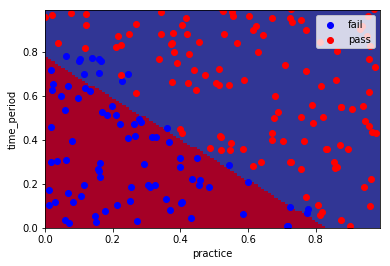

In [125]:
###第二个支持向量机模型（C=0.1,kernel='linear'）
svc = SVC(C=0.1,kernel='linear',probability=True,random_state=0)
svc.fit(X_train,Y_train)
Y_test['pred'] = svc.predict_proba(X_test)
plot_pic(svc,X_test,Y_test['label'])

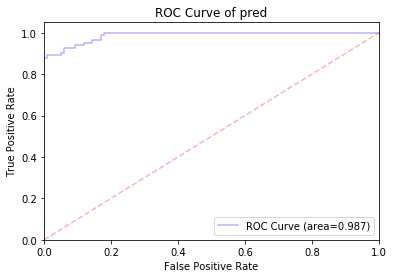

In [126]:
auc_fig = auc_calc(Y_test,['pred'],['label'])['auc_fig']
auc_fig

0.881769326168
0.522821324535


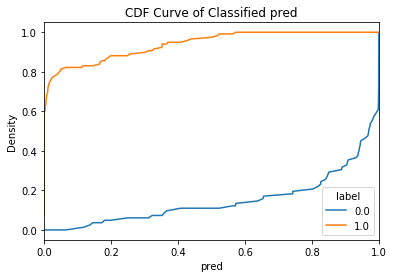

In [127]:
ks_dict = ks_calc(Y_test,['pred'],['label'])
print(ks_dict['ks'])
print(ks_dict['split'])
ks_dict['ks_fig']

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


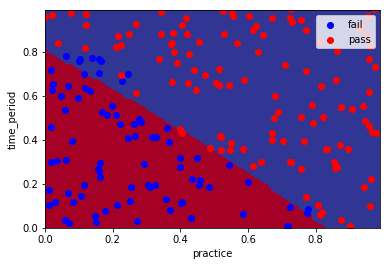

In [128]:
###第三个支持向量机模型（C=1,kernel='rbf'）
svc = SVC(C=1,kernel='rbf',probability=True,random_state=0)
svc.fit(X_train,Y_train)
Y_test['pred'] = svc.predict_proba(X_test)
plot_pic(svc,X_test,Y_test['label'])

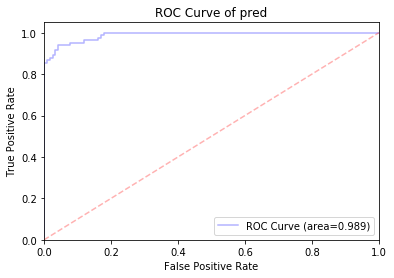

In [129]:
auc_fig = auc_calc(Y_test,['pred'],['label'])['auc_fig']
auc_fig

0.896651508888
0.331611051988


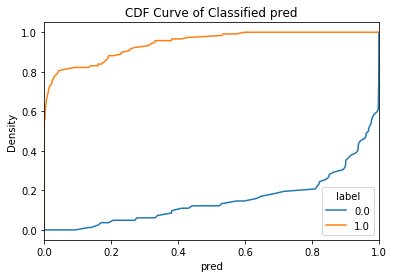

In [130]:
ks_dict = ks_calc(Y_test,['pred'],['label'])
print(ks_dict['ks'])
print(ks_dict['split'])
ks_dict['ks_fig']

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


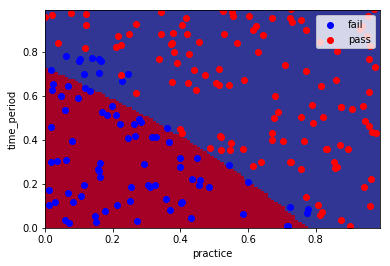

In [133]:
###第四个支持向量机模型（C=0.1,kernel='rbf'）
svc = SVC(C=0.1,kernel='rbf',probability=True,random_state=0)
svc.fit(X_train,Y_train)
Y_test['pred'] = svc.predict_proba(X_test)
plot_pic(svc,X_test,Y_test['label'])

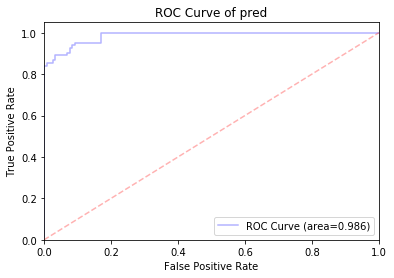

In [134]:
auc_fig = auc_calc(Y_test,['pred'],['label'])['auc_fig']
auc_fig

0.857999173212
0.26388298156


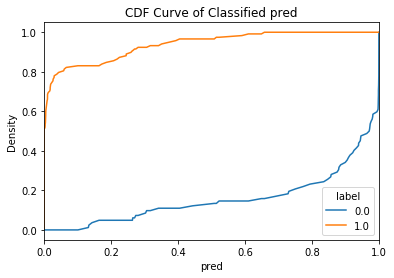

In [135]:
ks_dict = ks_calc(Y_test,['pred'],['label'])
print(ks_dict['ks'])
print(ks_dict['split'])
ks_dict['ks_fig']

## 训练决策树模型

决策树可以处理非线性数据，优点是训练速度和预测速度都很快，并且可解释性强；缺点是单棵决策树容易造成过拟合。

本章重点数学知识：二叉树、信息熵、基尼指数

算法理论详见周志华《机器学习》4.1、4.2、4.3

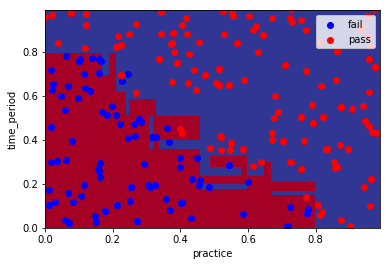

In [136]:
###第一个决策树模型（criterion='gini'）
dtree = DecisionTreeClassifier(criterion='gini',random_state=0)
dtree.fit(X_train,Y_train)
Y_test['pred'] = dtree.predict_proba(X_test)
plot_pic(dtree,X_test,Y_test['label'])

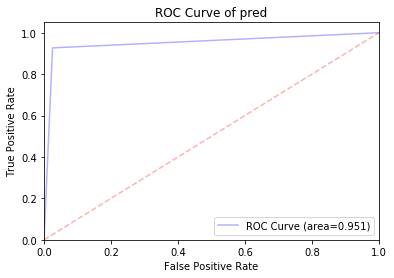

In [137]:
auc_fig = auc_calc(Y_test,['pred'],['label'])['auc_fig']
auc_fig

0.901405539479
0.0


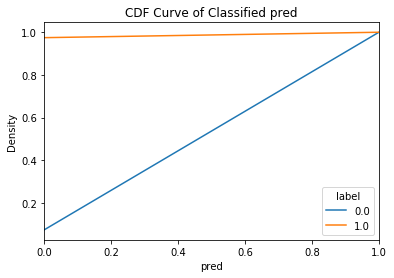

In [138]:
ks_dict = ks_calc(Y_test,['pred'],['label'])
print(ks_dict['ks'])
print(ks_dict['split'])
ks_dict['ks_fig']

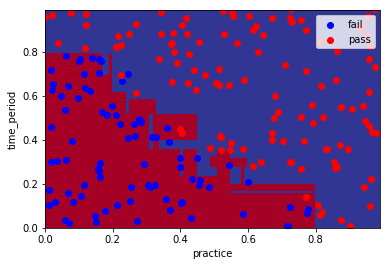

In [140]:
###第二个决策树模型（criterion='entropy'）
dtree = DecisionTreeClassifier(criterion='entropy',random_state=0)
dtree.fit(X_train,Y_train)
Y_test['pred'] = dtree.predict_proba(X_test)
plot_pic(dtree,X_test,Y_test['label'])

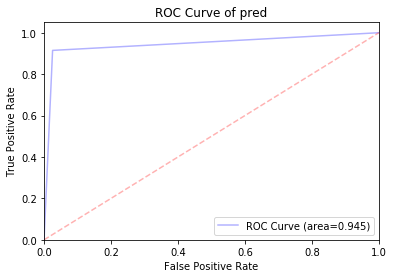

In [141]:
auc_fig = auc_calc(Y_test,['pred'],['label'])['auc_fig']
auc_fig

0.889210417528
0.0


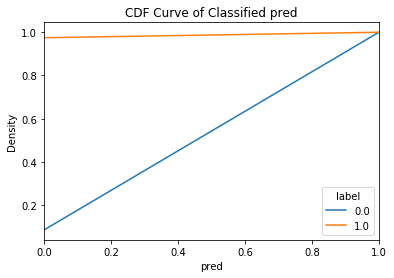

In [142]:
ks_dict = ks_calc(Y_test,['pred'],['label'])
print(ks_dict['ks'])
print(ks_dict['split'])
ks_dict['ks_fig']